cuda
tensor(0., device='cuda:0')
tensor(0.+0.j, device='cuda:0')
torch.Size([500])


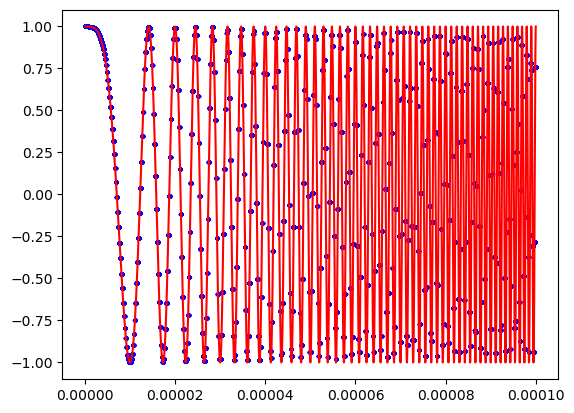

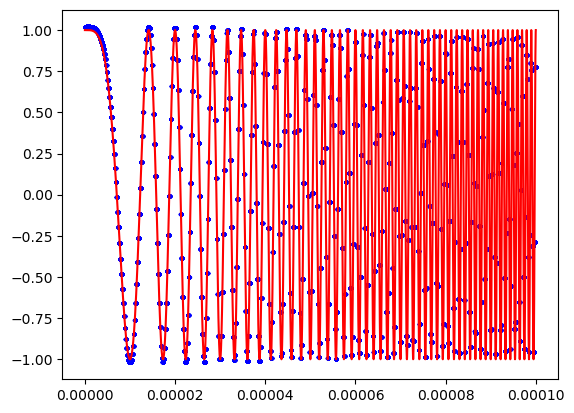

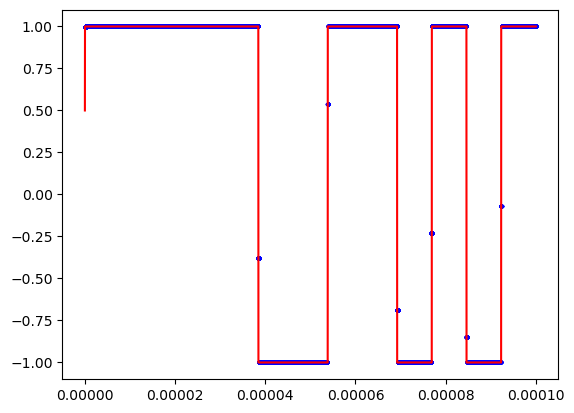

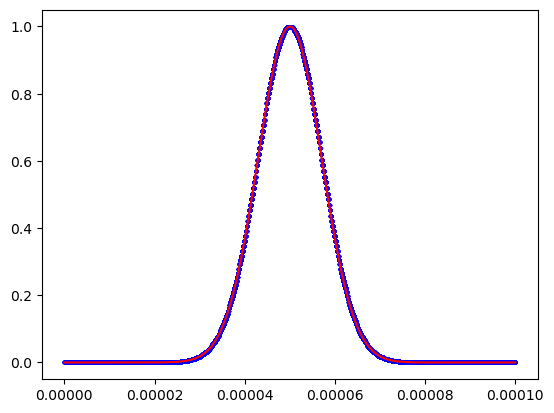

In [29]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from pulses import RadarPulseGenerator, CommPulseGenerator

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

L = 100
B = 1e6
K = 5
Tb = 1e-6
T = Tb * L
b = torch.tensor([+1, +1, +1, +1, +1, -1, -1, +1, +1, -1, +1, -1, +1], device=device)

t = torch.linspace(0, 1e-4, int(1e5), device=device)
myCommPulses = CommPulseGenerator(t, Tb, T, device)
myRadarPulses = RadarPulseGenerator(t, Tb, T, device)

print(torch.sum(myCommPulses.TDMA_pulse(0, 1, K) * myCommPulses.TDMA_pulse(0, 2, K)))
print(torch.sum(myCommPulses.OFDMA_pulse(2, 3) * myCommPulses.OFDMA_pulse(1, 4)))

g_funcs = lambda l, k: myCommPulses.TDMA_pulse(l, k, K)
g_vec = torch.zeros((L*K, len(t)), device=device, dtype=torch.complex64)
for l in range(L):
    for k in range(K):
        g_vec[l*K + k, :] = g_funcs(l, k+1)

Q = torch.matmul(g_vec, g_vec.conj().T)*(t[1]-t[0])

R = myRadarPulses.LFM_pulse(B).repeat(K*L, 1)
nom = torch.matmul(R[0,:][torch.newaxis, :], g_vec.conj().T)*(t[1]-t[0])
nom2 = torch.abs(nom)**2
denom_ = torch.sum(nom2.reshape((100,5)), dim=0).repeat((1,100))
denum = np.sqrt(1/L)*torch.sqrt(denom_)
c_opt_prime = nom/denum
c_opt_prime = c_opt_prime[0, :]
G = torch.diag(torch.matmul(R, g_vec.to(torch.complex64).conj().T))*(t[1]-t[0])
c_opt = torch.matmul(G, torch.inverse(Q.to(torch.complex64)))

s_opt = torch.sum(c_opt[:, torch.newaxis].repeat(1, len(t)) * g_vec, dim=0)
plt.figure()
plt.plot(t.cpu().numpy(), np.real(s_opt.cpu().numpy()), 'b', marker='.', linestyle='', linewidth=1.5, markersize=3)
plt.plot(t.cpu().numpy(), np.real(myRadarPulses.LFM_pulse(B).cpu().numpy()), 'r', linestyle='-', linewidth=1.5, markersize=3)

s_opt = torch.sum(c_opt_prime[:, torch.newaxis].repeat(1, len(t)) * g_vec, dim=0)
plt.figure()
plt.plot(t.cpu().numpy(), np.real(s_opt.cpu().numpy()), 'b', marker='.', linestyle='', linewidth=1.5, markersize=3)
plt.plot(t.cpu().numpy(), np.real(myRadarPulses.LFM_pulse(B).cpu().numpy()), 'r', linestyle='-', linewidth=1.5, markersize=3)

#====================================================================================
R = myRadarPulses.Barker_pulse(b).repeat(K*L, 1)
nom = torch.matmul(R[0,:][torch.newaxis, :], g_vec.conj().T)*(t[1]-t[0])
nom2 = torch.abs(nom)**2
denom_ = torch.sum(nom2.reshape((100,5)), dim=0).repeat((1,100))
denum = np.sqrt(1/L)*torch.sqrt(denom_)
c_opt_prime = nom/denum
c_opt_prime = c_opt_prime[0, :]
G = torch.diag(torch.matmul(R.to(torch.complex64), g_vec.to(torch.complex64).conj().T))*(t[1]-t[0])
c_opt = torch.matmul(G, torch.inverse(Q.to(torch.complex64)))

s_opt = torch.sum(c_opt[:, torch.newaxis].repeat(1, len(t)) * g_vec, dim=0)
plt.figure()
plt.plot(t.cpu().numpy(), np.real(s_opt.cpu().numpy()), 'b', marker='.', linestyle='', linewidth=1.5, markersize=3)
plt.plot(t.cpu().numpy(), np.real(myRadarPulses.Barker_pulse(b).cpu().numpy()), 'r', linestyle='-', linewidth=1.5, markersize=3)


#====================================================================================
R = myRadarPulses.Gaussian_pulse(B).repeat(K*L, 1)
G = torch.diag(torch.matmul(R.to(torch.complex64), g_vec.to(torch.complex64).conj().T))*(t[1]-t[0])
c_opt = torch.matmul(G, torch.inverse(Q.to(torch.complex64)))

s_opt = torch.sum(c_opt[:, torch.newaxis].repeat(1, len(t)) * g_vec, dim=0)
plt.figure()
plt.plot(t.cpu().numpy(), np.real(s_opt.cpu().numpy()), 'b', marker='.', linestyle='', linewidth=1.5, markersize=3)
plt.plot(t.cpu().numpy(), np.real(myRadarPulses.Gaussian_pulse(B).cpu().numpy()), 'r', linestyle='-', linewidth=1.5, markersize=3)


# c_opt2 = torch.zeros(L*K, device=device)
# for l in range(L):
#     for k in range(K):
#         c_opt2[l*K + k] =  torch.sum(myRadarPulses.LFM_pulse(B) * torch.conj(g_funcs(l, k).to(torch.complex64)))/torch.sum(g_funcs(l, k).to(torch.complex64) * torch.conj(g_funcs(l, k).to(torch.complex64)))

# plt.figure()
# plt.plot(np.real(c_opt2.cpu().numpy()))
# plt.figure()
# plt.plot(t.cpu().numpy(), np.real(myRadarPulses.LFM_pulse(B).cpu().numpy()))

# plt.figure()
# plt.plot(t.cpu().numpy(), np.real(myRadarPulses.Gaussian_pulse(B).cpu().numpy()))

# plt.figure()
# plt.plot(t.cpu().numpy(), np.real(myRadarPulses.Barker_pulse(b).cpu().numpy()))

# plt.figure()
# plt.plot(t.cpu().numpy(), np.real(myCommPulses.TDMA_pulse(1, 2, 3).cpu().numpy()))

# plt.figure()
# plt.plot(t.cpu().numpy(), np.real(myCommPulses.OFDMA_pulse(2, 2).cpu().numpy()))

# print(torch.sum(myCommPulses.TDMA_pulse(1, 2, 3) * myCommPulses.TDMA_pulse(1, 1, 3))*(t[2]-t[1]))

torch.Size([1, 100000])